## Load

In [4]:
import pandas as    pd
data = pd.read_csv('dataset.tsv', sep='\t', index_col=0)

In [5]:
data.clean_text = data.clean_text.apply(eval)
data.bow = data.bow.apply(eval)
data.entities = data.entities.apply(eval)

In [6]:
data.index = pd.Index(list(range(len(data))))

## LDA features

In [7]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, LdaMulticore

In [8]:
corpus = data.bow
dictionary = Dictionary(documents=data.clean_text.values)
print("Found {} words.".format(len(dictionary.values())))

Found 1882 words.


In [9]:
num_topics = 400
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [10]:
import numpy as np

In [11]:
def document_to_lda_features(lda_model, document):
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

In [12]:
def document_to_lda_features_by_word(lda_model, dictionary, document):
    if len(document)==0:
        return np.zeros(lda_model.num_topics, dtype="float32").reshape(1, lda_model.num_topics)
    featureVec = np.array(LDAmodel.get_document_topics(
        dictionary.doc2bow([document[0]]), minimum_probability=0))[:,1].reshape(1, lda_model.num_topics)
    for word in document[1:]:
        featureVec = np.vstack([featureVec,
                                np.array(LDAmodel.get_document_topics(
                                    dictionary.doc2bow([word]), minimum_probability=0))[:,1]])
    return featureVec

In [13]:
data['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      data.bow))

In [14]:
X_lda = np.array(list(map(np.array, data.lda_features)))

## NN

In [15]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

## BiLSTM by word

In [16]:
lengths = data['clean_text'].apply(len).sort_values(ascending=False)
sorted_idx = lengths[lengths>0].index
seq_tensor = nn.utils.rnn.pad_sequence(tuple(data.loc[sorted_idx]['clean_text'].apply(lambda x: 
                                                                    torch.FloatTensor(
                                                                    #    get_w2v_features_by_word(W2Vmodel, x)
                                                                        torch.from_numpy(document_to_lda_features_by_word(LDAmodel, dictionary, x)).float()
                                                                    ))))
lengths = lengths[lengths>0].values

In [17]:
len(lengths), len(sorted_idx)

(3272, 3272)

In [18]:
X_w2v_packed = nn.utils.rnn.pack_padded_sequence(seq_tensor, lengths)
#padded = pad_packed_sequence(out, batch_first=True)

In [19]:
seq_tensor.size()

torch.Size([12, 3272, 400])

In [20]:
X_w2v_packed[0].size()

torch.Size([11363, 400])

In [21]:
num_topics = 400
output_size = 600

In [22]:
lstm = nn.LSTM(num_topics, output_size, bidirectional=True)
packed_output, (ht, ct) = lstm(X_w2v_packed)
output, _ = nn.utils.rnn.pad_packed_sequence(packed_output)

#final hidden state
print (ht[-1])

tensor([[ 0.0124, -0.0140, -0.0056,  ...,  0.0023,  0.0256,  0.0138],
        [ 0.0083, -0.0068,  0.0020,  ...,  0.0058,  0.0282,  0.0231],
        [ 0.0092, -0.0064,  0.0042,  ...,  0.0080,  0.0280,  0.0238],
        ...,
        [ 0.0062, -0.0073,  0.0032,  ..., -0.0011,  0.0149,  0.0045],
        [ 0.0056, -0.0108,  0.0069,  ...,  0.0004,  0.0175,  0.0040],
        [ 0.0039, -0.0084,  0.0027,  ..., -0.0048,  0.0159,  0.0096]],
       grad_fn=<SelectBackward>)


In [23]:
ht[-1].size()

torch.Size([3272, 600])

In [24]:
ht[-1][pd.DataFrame(sorted_idx).sort_values(0).index]

tensor([[ 0.0058, -0.0067,  0.0051,  ...,  0.0085,  0.0266,  0.0100],
        [ 0.0027, -0.0050,  0.0052,  ...,  0.0073,  0.0313,  0.0143],
        [ 0.0048, -0.0068,  0.0023,  ...,  0.0092,  0.0241,  0.0226],
        ...,
        [ 0.0021, -0.0026,  0.0122,  ...,  0.0046,  0.0214,  0.0095],
        [ 0.0060, -0.0086,  0.0048,  ...,  0.0026,  0.0245,  0.0075],
        [ 0.0017, -0.0032,  0.0120,  ...,  0.0032,  0.0190,  0.0069]],
       grad_fn=<TakeBackward>)

In [25]:
X_bilstm_ht = ht[-1]#[pd.DataFrame(sorted_idx).sort_values(0).index]

## Dataset

In [26]:
K = len(data['intent'].unique())

In [27]:
X = X_bilstm_ht.detach().numpy()
y = data.loc[sorted_idx]['intent']

In [28]:
X.shape, y.shape

((3272, 600), (3272,))

---

In [29]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [30]:
from sklearn.mixture import GaussianMixture

In [55]:
km = KMeans(K).fit(X)

In [87]:
km = AgglomerativeClustering(K).fit(X)

In [93]:
km = GaussianMixture(K, tol=1e-6, max_iter=500).fit(X)

---

In [31]:
%matplotlib inline

In [57]:
comp = pd.DataFrame(data.loc[sorted_idx][['text', 'intent']])

In [58]:
comp['clusters'] = km.predict(X)

In [59]:
comp['clusters'] = km.labels_

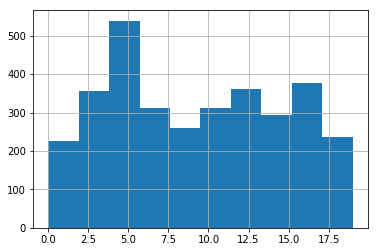

In [60]:
comp['clusters'].hist()

In [61]:
pd.pivot_table(comp, index='intent', columns='clusters', aggfunc=len, fill_value=0)\
            .style.background_gradient(axis=1)

In [32]:
from sklearn.metrics import *

In [33]:
def purity_score(y_true, y_pred):
    contingency_matrix = cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [64]:
(
    purity_score(comp['intent'], comp['clusters']),
    silhouette_score(X, comp['clusters']),
    homogeneity_score(comp['intent'], comp['clusters']),
    completeness_score(comp['intent'], comp['clusters']),
)

(0.27903422982885084, 0.2700102, 0.22662359625828674, 0.22988971723767274)

## GO

In [34]:
lengths = data['clean_text'].apply(len).sort_values(ascending=False)
sorted_idx = lengths[lengths>0].index
seq_tensor = nn.utils.rnn.pad_sequence(tuple(data.loc[sorted_idx]['clean_text'].apply(lambda x: 
                                                                    torch.FloatTensor(
                                                                    #    get_w2v_features_by_word(W2Vmodel, x)
                                                                        torch.from_numpy(document_to_lda_features_by_word(LDAmodel, dictionary, x)).float()
                                                                    ))))
lengths = lengths[lengths>0].values
X_w2v_packed = nn.utils.rnn.pack_padded_sequence(seq_tensor, lengths)
lstm = nn.LSTM(num_topics, output_size, bidirectional=True)
packed_output, (ht, ct) = lstm(X_w2v_packed)
output, _ = nn.utils.rnn.pad_packed_sequence(packed_output)
X_bilstm_ht = ht[-1]#[pd.DataFrame(sorted_idx).sort_values(0).index]
X = X_bilstm_ht.detach().numpy()
y = data.loc[sorted_idx]['intent']

100 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
200 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
300 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
400 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
500 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
600 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
700 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
800 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
900 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture


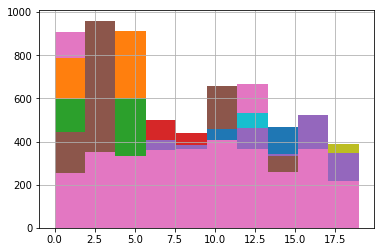

In [35]:
raw_results = []
cms = []
np.random.seed(0)
num_topics=400

for output_size in range(100,1000,100):
    lstm = nn.LSTM(num_topics, output_size, bidirectional=True)
    packed_output, (ht, ct) = lstm(X_w2v_packed)
    output, _ = nn.utils.rnn.pad_packed_sequence(packed_output)
    X_bilstm_ht = ht[-1]#[pd.DataFrame(sorted_idx).sort_values(0).index]
    X = X_bilstm_ht.detach().numpy()

    print('%d features'%output_size)
    for model in [KMeans, AgglomerativeClustering, GaussianMixture]:
        print('\t %s'%str(model).split('.')[-1][:-2])
        try:
            km = model(K, tol=1e-6, max_iter=500).fit(X)
        except:
            km = model(K).fit(X)


        comp = pd.DataFrame(data.loc[sorted_idx][['text', 'intent']])
        try:
            comp['clusters'] = km.labels_
        except:
            comp['clusters'] = km.predict(X)

        comp['clusters'].hist().get_figure().savefig('lda/hist_%d.pdf'%num_topics)
        cms += [pd.pivot_table(comp, index='intent', columns='clusters', aggfunc=len, fill_value=0)\
                    .style.background_gradient(axis=1)]
        raw_results += [(
            purity_score(comp['intent'], comp['clusters']),
            silhouette_score(X, comp['clusters']),
            homogeneity_score(comp['intent'], comp['clusters']),
            completeness_score(comp['intent'], comp['clusters']),
            output_size,
            str(model).split('.')[-1][:-2])
        ]

In [36]:
results = pd.DataFrame(raw_results,
                       columns=['purity', 'silhouette', 'homogeneity', 
                                'completeness', 'features num', 'model'])

In [37]:
import seaborn as sns; sns.set()

In [38]:
results.to_csv('bilstm_lda/scores.csv')

In [39]:
results.style.background_gradient(axis=0)

,purity,silhouette,homogeneity,completeness,features num,model
0,0.273227,0.297786,0.224472,0.226726,100,KMeans
1,0.275978,0.273035,0.224381,0.233863,100,AgglomerativeClustering
2,0.267421,0.237353,0.233039,0.228246,100,GaussianMixture
3,0.272922,0.293767,0.226929,0.230241,200,KMeans
4,0.274756,0.257568,0.227099,0.236008,200,AgglomerativeClustering
5,0.277812,0.218906,0.236415,0.234297,200,GaussianMixture
6,0.274144,0.262896,0.234865,0.235407,300,KMeans
7,0.279645,0.238228,0.228457,0.232824,300,AgglomerativeClustering
8,0.271699,0.231775,0.228674,0.223941,300,GaussianMixture
9,0.277812,0.266156,0.230448,0.231981,400,KMeans


In [41]:
results.groupby('features num').mean()

,purity,silhouette,homogeneity,completeness
features num,,,,
100,0.272209,0.269391,0.227297,0.229612
200,0.275163,0.256747,0.230148,0.233515
300,0.275163,0.244300,0.230666,0.230724
400,0.272922,0.241601,0.224182,0.226058
500,0.276284,0.252942,0.224462,0.229822
600,0.277404,0.249366,0.229247,0.234297
700,0.277608,0.261616,0.225168,0.228572
800,0.273737,0.261578,0.225791,0.229699
900,0.280053,0.253115,0.228320,0.231659


## Quick easy classifier

- 10 fold cross validation on 100 examples from labelled data
- Feed forward network
- Input = sequence of word representations

In [302]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

def balanced_sample_maker(X, y, sample_size, random_seed=42):
    uniq_levels = np.unique(y)
    uniq_counts = {level: sum(y == level) for level in uniq_levels}

    if not random_seed is None:
        np.random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx
    # oversampling on observations of each label
    balanced_copy_idx = []
    for gb_level, gb_idx in groupby_levels.items():
        over_sample_idx = np.random.choice(gb_idx, size=sample_size, replace=True).tolist()
        balanced_copy_idx+=over_sample_idx
    np.random.shuffle(balanced_copy_idx)

    data_train=X[balanced_copy_idx]
    labels_train=y[balanced_copy_idx]
    if  ((len(data_train)) == (sample_size*len(uniq_levels))):
        print('number of sampled example ', sample_size*len(uniq_levels), 'number of sample per class ', sample_size, ' #classes: ', len(list(set(uniq_levels))))
    else:
        print('number of samples is wrong ')

    labels, values = zip(*Counter(labels_train).items())
    print('number of classes ', len(list(set(labels_train))))
    check = all(x == values[0] for x in values)
    print(check)
    if check == True:
        print('Good all classes have the same number of examples')
    else:
        print('Repeat again your sampling your classes are not balanced')
    indexes = np.arange(len(labels))
    width = 0.5
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()
    return data_train,labels_train

In [303]:
X = X_bilstm_ht.detach().numpy()
y = data.loc[sorted_idx]['intent']
#y = data['intent']

number of sampled example  1000 number of sample per class  50  #classes:  20
number of classes  21
False
Repeat again your sampling your classes are not balanced


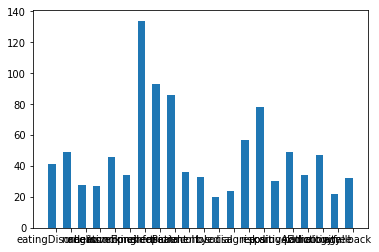

In [311]:
X_train,y_train=balanced_sample_maker(X,y,50)

In [301]:
pd.DataFrame([y_train.values, y_train.values]).T.groupby(0).count().sort_values(1).tail()

,1
0,
risk,57
pain,78
treatment,86
infoPatient,93
sleep,134


In [263]:
y_train = y_train.fillna('hello')

In [264]:
bad_df = y.index.isin(y_train.index)
X_test = pd.DataFrame(X)[~bad_df]
y_test = data.loc[sorted_idx][~bad_df]['intent']

In [258]:
from sklearn.svm import SVC

In [265]:
clf = SVC(kernel='linear', C=1, random_state=0).fit(X_train, y_train)

In [266]:
clf.score(X_test, y_test)

0.05681332763776164

In [267]:
clf.predict(X_test[:40])

array(['treatment', 'treatment', 'treatment', 'treatment', 'treatment',
       'treatment', 'treatment', 'treatment', 'treatment', 'treatment',
       'treatment', 'treatment', 'treatment', 'treatment', 'treatment',
       'treatment', 'treatment', 'treatment', 'treatment', 'treatment',
       'treatment', 'treatment', 'treatment', 'treatment', 'treatment',
       'treatment', 'treatment', 'treatment', 'treatment', 'treatment',
       'treatment', 'treatment', 'treatment', 'treatment', 'treatment',
       'treatment', 'treatment', 'treatment', 'treatment', 'treatment'],
      dtype=object)

In [268]:
from sklearn.model_selection import cross_val_score

In [269]:
cv_scores = cross_val_score(clf, X_test, y_test, cv=10) 

In [270]:
cv_scores

array([0.1147541 , 0.17283951, 0.23849372, 0.2278481 , 0.21367521,
       0.26293103, 0.27391304, 0.29694323, 0.22907489, 0.19469027])

In [271]:
print('{:2.3} + {:2.3}%'.format(np.mean(cv_scores), np.std(cv_scores)))

0.223 + 0.0501%


In [272]:
from sklearn.metrics import confusion_matrix

In [273]:
clf_res = pd.DataFrame([clf.predict(X_test), y_test]).T
clf_res.columns = ['class', 'intent']

In [274]:
cm = pd.DataFrame(confusion_matrix(clf_res['intent'], clf_res['class']), 
             index=clf.classes_, columns=clf.classes_)

In [275]:
clf_res.groupby('class').count()

,intent
class,
sleep,1587
treatment,754


In [276]:
clf_res.groupby('intent').count()

,class
intent,
activity,132
agree,55
alcohol,76
bye,58
disagree,42
drugAddiction,152
eatingDisorders,120
fallback,42
hello,74


In [277]:
cm.style.set_table_styles(
    [dict(selector="th",props=[('max-width', '120px')]),
        dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"), 
                        ('transform', 'rotateZ(180deg)'),
                        ])]
).background_gradient(axis=0)

,activity,agree,alcohol,bye,disagree,drugAddiction,eatingDisorders,fallback,hello,incomprehension,infoPatient,negativeEmo,pain,pathology,positiveEmo,risk,sleep,smoking,social,treatment
activity,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117,0,0,15
agree,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55,0,0,0
alcohol,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,0,0,40
bye,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,57,0,0,1
disagree,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0
drugAddiction,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,66,0,0,86
eatingDisorders,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,56,0,0,64
fallback,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0
hello,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72,0,0,2
incomprehension,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,79,0,0,10


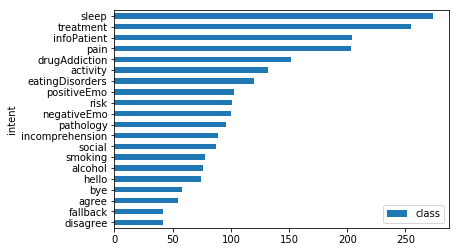

In [278]:
clf_res.groupby('intent').count().sort_values('class').plot(kind='barh')

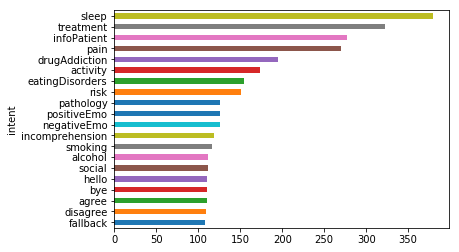

In [78]:
data.groupby('intent').count()['text'].sort_values().plot(kind='barh')

In [79]:
data.loc[0]

entities             [{'start': 34, 'end': 38, 'value': 'wine', 'en...
intent                                                         alcohol
text                 i’m drinking at least a bottle of wine a day i...
tokenized_text       [i, m, drinking, at, least, a, bottle, of, win...
stopwords_removed    [i, m, drinking, at, least, a, bottle, of, win...
lemmatized_text      [i, m, drinking, at, least, a, bottle, of, win...
stemmed_text         [i, m, drink, at, least, a, bottl, of, wine, a...
bow                  [(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...
w2v_features         [-0.023403363, -0.00012617472, -0.007538838, 0...
glove_features       [0.5747946, 0.19084111, -0.12595873, -0.176687...
Name: 0, dtype: object

## Label new data

In [80]:
import json

In [88]:
new_data = list(map(lambda x: x['post'], json.loads(open('subset.json', 'r').read())))[:100]

In [89]:
new_data = sum(list(map(lambda x: x.split('\n'), new_data)), [])

In [90]:
new_data = sum(list(map(lambda x: x.split('.'), new_data)), [])

In [91]:
new_data = list(map(lambda x: x.strip(), new_data))

In [92]:
new_data = list(filter(lambda x: len(x)>0, new_data))

In [93]:
new_dt = pd.DataFrame(new_data, columns=['text'])

In [94]:
lda_preprocessing(new_dt)

In [149]:
new_dt['stem_len'] = new_dt.stemmed_text.apply(len)

In [152]:
new_dt[(new_dt['stem_len']>0)&(new_dt['stem_len']<=10)]

,text,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,stem_len
0,how about a divorce support group for those wh...,"[how, about, a, divorce, support, group, for, ...","[divorce, support, group, process, divorced, n...","[divorce, support, group, process, divorced, n...","[divorc, support, group, process, divorc, nt, ...","[(104, 1), (234, 1), (1121, 1), (1249, 1), (13...",7
1,i know when i was divorced 6 years ago after 2...,"[i, know, when, i, was, divorced, 6, years, ag...","[divorced, 6, years, ago, 23, years, marriage,...","[divorced, 6, year, ago, 23, year, marriage, g...","[divorc, 6, year, ago, 23, year, marriag, god,...","[(9, 2), (155, 1), (178, 1), (194, 1), (1356, 1)]",9
2,anyone have any other comments?,"[anyone, have, any, other, comments, ?]","[comments, ?]","[comment, ?]","[comment, ?]","[(966, 1), (1809, 1)]",2
3,i'm welcoming all suggestions and comments,"[i, m, welcoming, all, suggestions, and, comme...","[welcoming, suggestions, comments]","[welcoming, suggestion, comment]","[welcom, suggest, comment]","[(1809, 1)]",3
4,i just need some sound advice,"[i, just, need, some, sound, advice]","[sound, advice]","[sound, advice]","[sound, advic]","[(1374, 1)]",2
5,i have a dd who is 2,"[i, have, a, dd, who, is, 2]","[dd, 2]","[dd, 2]","[dd, 2]","[(26, 1)]",2
6,"she is very smart, tall for her age, speaks in...","[she, is, very, smart, tall, for, her, age, sp...","[smart, tall, age, speaks, complete, sentences]","[smart, tall, age, speaks, complete, sentence]","[smart, tall, age, speak, complet, sentenc]","[(98, 1), (353, 1), (863, 1), (991, 1)]",6
7,she appears to be 3 instead of just turning 2,"[she, appears, to, be, 3, instead, of, just, t...","[appears, 3, turning, 2]","[appears, 3, turning, 2]","[appear, 3, turn, 2]","[(26, 1), (114, 1), (531, 1), (918, 1)]",4
8,she goes to daycare full-time,"[she, goes, to, daycare, fulltime]","[daycare, fulltime]","[daycare, fulltime]","[daycar, fulltim]",[],2
9,it's an in-home daycare with only one other ch...,"[it, s, an, inhome, daycare, with, only, one, ...","[inhome, daycare, child]","[inhome, daycare, child]","[inhom, daycar, child]","[(444, 1)]",3


In [95]:
data['glove_features'] = list(map(lambda sen_group:
                                      get_w2v_features(model, sen_group),
                                      new_dt.text))

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()


ValueError: Length of values does not match length of index

In [ ]:
X_new_glove = np.array(list(map(np.array, new_dt.glove_features)))

In [153]:
new_dt['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      new_dt.bow))

In [154]:
X_new_lda = np.array(list(map(np.array, new_dt.lda_features)))

In [155]:
new_dt[(new_dt['stem_len']>0)&(new_dt['stem_len']<=10)]['prediction'] = clf.predict(X_new_lda)

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [157]:
new_dt

,text,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,stem_len,lda_features
0,how about a divorce support group for those wh...,"[how, about, a, divorce, support, group, for, ...","[divorce, support, group, process, divorced, n...","[divorce, support, group, process, divorced, n...","[divorc, support, group, process, divorc, nt, ...","[(104, 1), (234, 1), (1121, 1), (1249, 1), (13...",7,"[0.3889574408531189, 0.0035985582508146763, 0...."
1,i know when i was divorced 6 years ago after 2...,"[i, know, when, i, was, divorced, 6, years, ag...","[divorced, 6, years, ago, 23, years, marriage,...","[divorced, 6, year, ago, 23, year, marriage, g...","[divorc, 6, year, ago, 23, year, marriag, god,...","[(9, 2), (155, 1), (178, 1), (194, 1), (1356, 1)]",9,"[0.14830075204372406, 0.004112637601792812, 0...."
2,anyone have any other comments?,"[anyone, have, any, other, comments, ?]","[comments, ?]","[comment, ?]","[comment, ?]","[(966, 1), (1809, 1)]",2,"[0.010379879735410213, 0.009596155025064945, 0..."
3,i'm welcoming all suggestions and comments,"[i, m, welcoming, all, suggestions, and, comme...","[welcoming, suggestions, comments]","[welcoming, suggestion, comment]","[welcom, suggest, comment]","[(1809, 1)]",3,"[0.015569516457617283, 0.01439423207193613, 0...."
4,i just need some sound advice,"[i, just, need, some, sound, advice]","[sound, advice]","[sound, advice]","[sound, advic]","[(1374, 1)]",2,"[0.5155695080757141, 0.01439423207193613, 0.01..."
5,i have a dd who is 2,"[i, have, a, dd, who, is, 2]","[dd, 2]","[dd, 2]","[dd, 2]","[(26, 1)]",2,"[0.015569516457617283, 0.01439423207193613, 0...."
6,"she is very smart, tall for her age, speaks in...","[she, is, very, smart, tall, for, her, age, sp...","[smart, tall, age, speaks, complete, sentences]","[smart, tall, age, speaks, complete, sentence]","[smart, tall, age, speak, complet, sentenc]","[(98, 1), (353, 1), (863, 1), (991, 1)]",6,"[0.006227806676179171, 0.20575812458992004, 0...."
7,she appears to be 3 instead of just turning 2,"[she, appears, to, be, 3, instead, of, just, t...","[appears, 3, turning, 2]","[appears, 3, turning, 2]","[appear, 3, turn, 2]","[(26, 1), (114, 1), (531, 1), (918, 1)]",4,"[0.006227806676179171, 0.005757692735642195, 0..."
8,she goes to daycare full-time,"[she, goes, to, daycare, fulltime]","[daycare, fulltime]","[daycare, fulltime]","[daycar, fulltim]",[],2,"[0.031139032915234566, 0.02878846414387226, 0...."
9,it's an in-home daycare with only one other ch...,"[it, s, an, inhome, daycare, with, only, one, ...","[inhome, daycare, child]","[inhome, daycare, child]","[inhom, daycar, child]","[(444, 1)]",3,"[0.015569516457617283, 0.01439423207193613, 0...."


In [121]:
data.intent.unique()

array(['alcohol', 'eatingDisorders', 'pathology', 'drugAddiction',
       'smoking', 'treatment', 'sleep', 'infoPatient', 'pain', 'activity',
       'incomprehension', 'negativeEmo', 'positiveEmo', 'fallback',
       'social', 'agree', 'disagree', 'hello', 'bye', 'risk'],
      dtype=object)

In [156]:
new_dt[new_dt.prediction == 'eatingDisorders']

AttributeError: 'DataFrame' object has no attribute 'prediction'

sentences embeddings

1. biLSTM
2. CNN
3. Emlo

different clustering models  as evaluation

purity + metrics

classification on obrained features

one-shot


** Further experiments with Sentence Representations

- use bidirectional LSTM to represent sentences
Each iput word is represented by concatenation of LDA and Word2Vec vectors

- use convolutional network 
Each iput word is represented by concatenation of LDA, Word2Vec vectors  and position information



too long sentences > 30

multiclass classification

mlp

In [80]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.c1 = nn.Conv1d(input_size, hidden_size, 2)
        self.p1 = nn.AvgPool1d(2)
        self.c2 = nn.Conv1d(hidden_size, hidden_size, 1)
        self.p2 = nn.AvgPool1d(2)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=0.01)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, inputs, hidden):
        batch_size = inputs.size(1)
        
        # Turn (seq_len x batch_size x input_size) into (batch_size x input_size x seq_len) for CNN
        inputs = inputs.transpose(0, 1).transpose(1, 2)

        # Run through Conv1d and Pool1d layers
        c = self.c1(inputs)
        p = self.p1(c)
        c = self.c2(p)
        p = self.p2(c)

        # Turn (batch_size x hidden_size x seq_len) back into (seq_len x batch_size x hidden_size) for RNN
        p = p.transpose(1, 2).transpose(0, 1)
        
        p = F.tanh(p)
        output, hidden = self.gru(p, hidden)
        conv_seq_len = output.size(0)
        output = output.view(conv_seq_len * batch_size, self.hidden_size) # Treating (conv_seq_len x batch_size) as batch_size for linear layer
        output = F.tanh(self.out(output))
        output = output.view(conv_seq_len, -1, self.output_size)
        return output, hidden

In [81]:
input_size = 20 #num topics
hidden_size = 50
output_size = 7
batch_size = 5
n_layers = 2
seq_len = 15 #number of examples

rnn = RNN(input_size, hidden_size, output_size, n_layers=n_layers)

inputs = Variable(torch.rand(seq_len, batch_size, input_size)) # seq_len x batch_size x 
outputs, hidden = rnn(inputs, None)
print('outputs', outputs.size()) # conv_seq_len x batch_size x output_size
print('hidden', hidden.size()) # n_layers x batch_size x hidden_size

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


outputs torch.Size([3, 5, 7])
hidden torch.Size([2, 5, 50])


In [89]:
inputs.size()

torch.Size([15, 5, 20])

In [236]:
inputs[0][0]

tensor([0.3456, 0.3990, 0.2212, 0.5093, 0.2816, 0.2991, 0.8876, 0.2649, 0.2128,
        0.2380, 0.1750, 0.6771, 0.4144, 0.0417, 0.7325, 0.4776, 0.2434, 0.5489,
        0.4855, 0.0281])

In [237]:
outputs[0][0]

tensor([ 0.0170,  0.0506, -0.0245,  0.0137,  0.0220, -0.1867, -0.1126],
       grad_fn=<SelectBackward>)

### batched

In [381]:
bi_clf(X_encoded[3])

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-3.0144, -3.0191, -2.9914, -3.0634, -2.9738, -3.0705, -2.9834, -3.0689,
         -2.9719, -2.9261, -2.9284, -2.9812, -2.9337, -3.0683, -2.8504, -3.0134,
         -3.0271, -2.9392, -3.0880, -3.0383]], grad_fn=<LogSoftmaxBackward>)

In [366]:
class BiLSTMC(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, label_size, batch_size, dropout=0.5):
        super(BiLSTMC, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.dropout = dropout
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, bidirectional=True)
        self.hidden2label = nn.Linear(hidden_dim*2, label_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # first is the hidden h
        # second is the cell c
        return (Variable(torch.zeros(2, self.batch_size, self.hidden_dim)),
                Variable(torch.zeros(2, self.batch_size, self.hidden_dim)))

    def forward(self, sentence):
        x = self.embeddings(sentence).view(len(sentence), self.batch_size, -1)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y = self.hidden2label(lstm_out[-1])
        log_probs = F.log_softmax(y)
        return log_probs

In [367]:
bi_clf = BiLSTMC(32, 124, encoder.vocab_size, 20, 1)

In [368]:
optimizer = torch.optim.Adam(bi_clf.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [369]:
train_idx = y_train.index
test_idx = y_test.index

In [370]:
X_encoded = nn.utils.rnn.pad_sequence(list(map(lambda x: encoder.encode(x), data['text'].values)))

In [371]:
vXtrain = torch.index_select(X_encoded, 1, Variable(torch.from_numpy(train_idx.values).long()))
vXtest = torch.index_select(X_encoded, 1, Variable(torch.from_numpy(test_idx.values).long()))
vytrain = torch.from_numpy(pd.get_dummies(y).loc[y_train.index].values)
vytest = torch.from_numpy(pd.get_dummies(y).loc[y_test.index].values)

In [372]:
vXtrain[0].size()

torch.Size([2000])

In [373]:
vytrain.size()

torch.Size([2000, 20])

In [ ]:
losses = []

for epoch in range(10):
    optimizer.zero_grad()
    yhat = bi_clf(vXtrain)
    loss = criterion(yhat, vytrain)
    loss.backward()
    losses.append(loss.data.item())
    optimizer.step()

In [44]:
from torchnlp.word_to_vector import GloVe

In [ ]:
vectors = GloVe(dim=30, name='6B')

In [214]:
encoder.vocab_size

2812

In [ ]:
from torchnlp.word_to_vector import FastText

vectors = FastText()
# Load vectors for any word as a `torch.FloatTensor`
vectors['hello']  # RETURNS: [torch.FloatTen

## HDP modeling

In [38]:
from gensim.models import HdpModel

In [ ]:
list(filter(lambda x: len(x) > 0, corpus))

In [148]:
hdp = HdpModel(corpus=list(filter(lambda x: len(x) > 0, corpus)), id2word=dictionary)

In [ ]:
hdp.print_topics()

In [128]:
def Diff(li1, li2): 
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2] 
    return tuple(li_dif)

In [123]:
Diff(data.tokenized_text[0], data.spacy_tokens[0])

['m', '’m']

In [117]:
data.spacy_tokens[0]

[i, ’m, drinking, at, least, a, bottle, of, wine, a, day, in, the, week]

In [158]:
data[['tokenized_text', 'spacy_tokens']]\
    .apply(lambda x: Diff(x['tokenized_text'], x['spacy_tokens']), axis=1).sort_values(ascending=False).drop_duplicates()

2793                                     (zpill, z, pill)
2615                                     (zdrug, z, drug)
3149                         (wrongheaded, wrong, headed)
2648                     (wouldnt, 8am, would, nt, 8, am)
2897                                       (wont, wo, nt)
1814                                 (weekend, week, end)
616                                      (weedfree, free)
507                                      (wan, na, wanna)
1882                                     (thats, that, s)
3055                 (secondhand, 34, second, hand, 3, 4)
20                 (reducingstopping, reducing, stopping)
1731                               (pingpong, ping, pong)
630                      (percosetnorco, percoset, norco)
617     (onandoff, opiateopioid, on, and, off, opiate,...
526                      (norcosopiates, norcos, opiates)
2848                             (nighttime, night, time)
2891                         (middleclass, middle, class)
3039          

In [165]:
data[['tokenized_text', 'spacy_tokens']].loc[509].values

array([list(['i', 'm', 'supposed', 'to', 'take', '6', '35mg', 'tablets', 'a', 'day', 'but', 'i', 'have', 'taken', '20', 'today']),
       list(['i', 'm', 'supposed', 'to', 'take', '6', '35', 'mg', 'tablets', 'a', 'day', 'but', 'i', 'have', 'taken', '20', 'today'])],
      dtype=object)